# DGM Lab 4 - Generative adversarial networks

In this lab session we are going to experiment with generative adversarial networks (GANs).

## Assignment 1

As done many times before (e.g. in lab session 1), load the MNIST dataset using `torchvision` and make sure that the data is normalized between $-1$ and $1$ (i.e. one of the GAN hacks we have covered in the lectures). Also pad the images to make then 32x32 pixels instead of 28x28 pixels. Create a `DataLoader` class that can be used to retrieve batches from the dataset.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

batch_size = 64

transform = transforms.Compose([
    transforms.Pad(2),                    # 28x28 → 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalization [-1, 1]
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.84MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]


## Assignment 2
Let's create our generator (G) and discriminator (D) models. Both will be based on a convolutional architecture, and we will largely follow the DCGAN guidelines (see lecture):
1. Use strided convolutions (instead of pooling operations)
2. Use BatchNorm in G and D
3. No fully-connected (dense) layers
4. Use ReLU in G, except for tanh at the output
5. Use LeakyReLU in D

But we have obtained good results by also using LeakyReLU in G as well (the choice is up to you). Here are our additional suggestions:
* Use 5 layers in both G and D. These are regular `Conv2d` layers in D, but `ConvTranspose2d` layers (sometimes also called deconvolution layers) in G. The `Conv2d` layers will reduce the spatial dimensions, while the `ConvTranspose2d` layers will increase them (so you can create larger and larger images by adding more deconvolution layers).
* The input of G will be an $N$-dimensional noise vector $\mathbf{z}$, which you treat as a 1x1 "image" with $N$ channels. Ideally, you then increase your image dimensions in an exponential fashion: 1x1 $\rightarrow$ 2x2 $\rightarrow$ 4x4 $\rightarrow$ 8x8 $\rightarrow$ 16x16 $\rightarrow$ 32x32 (so indeed: 5 layers in total). Reduce the number of channels in each layer in an exponential fashion as well. Consult the documentation on how you can achieve all this by playing with the kernel size, padding, stride and dilation (hint: dilation can be always be set to 1).
* The same goes for D, but here you reduce the spatial dimensions exponentially.
* Don't include any bias parameters in the convolutional layers.
* Keep the number of feature maps in G and D high enough to allow for reasonable expressiveness.
* Use a noise vector size $N$ of about 50

Check your models (and especially the output dimensions of G and D) by feeding in a random noise vector.

In [ ]:
import torch.nn as nn

nz = 50     # Noise vector size
ngf = 64    # Base size of feature maps in Generator
ndf = 64    # Base size of Discriminator

class Generator(nn.Module):
    def __init__(self, nz=nz, ngf=ngf, nc=1):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),  # 1 → 4
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),  # 4 → 8
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),  # 8 → 16
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),  # 16 → 32
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 3, 1, 1, bias=False),  # mantains 32x32
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),  # 32 → 16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # 16 → 8
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),  # 8 → 4
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # 4 → 2
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 2, 1, 0, bias=False),  # 2 → 1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1)


## Assignment 3
It is time to train our first GAN to mimic MNIST images. As in all lab sessions, we will write a train loop over a number of epochs. In each epoch we will construct and process minibatches that consist of either 100% real MNIST images or 100% fake images generated by G (as is suggested in one of the GAN hacks). A couple of important details you should consider:

* Since we train two models, you will need two optimizers. Use a very small learning rate (ca. 0.0001).
* We will use the non-saturating GAN objective to train G. This means that for D we maximize $\log(D(x)) + \log(1 - D(G(z)))$, and for G we maximize $\log(D(G(z)))$ (expectations are omitted).
* The GAN objectives for D and G look very much like the binary cross-entropy loss function, which is implemented by the `BCELoss` class:
$$\text{BCELoss} = -\left[y_n\cdot \log(x_n) + (1 - y_n)\cdot \log(1 - x_n)\right]$$
In this formula, $y_n$ is the target label ($0$ or $1$) and $x_n$ is the network's output (between $0$ and $1$). If you use $1$ as real target label and $0$ as fake target label to train D, and $1$ as target label to train G, you can make clever use of just a single instantiation of the `BCELoss` class.
* A possible training iteration could go as follows:
  1. Get a batch from the MNIST dataset, feed the batch through D, calculate the loss, calculate D's parameter gradients.
  2. Sample a batch $B$ of fake images through G, feed the batch through D, calculate the loss, calculate (and accumulate) D's parameter gradients.
  3. Do one optimization step for D.
  4. Use the same batch $B$, feed it through D, calculate the loss for G, calculate G's parameter gradients.
  5. Do one optimization step for G.
* Make sure to run everything on the GPU.
* Remember what we learned about momentum in the network's optimizer!
* Tip: you can mount your Google Drive to Google Colab. This allows you to persist your model parameters even after disconnection with Colab. We highly recommend that you look into this (we will compare different models in assignment 6).
* Tip (without obligation): create a batch of fixed random vectors that you can use to sample images from G every $x$ training iterations. You can arrange these images in a grid using the `make_grid` function from `torchvision.utils` and save this grid in a list. You can then submit this grid of images to Tensorboard, where you can easily inspect them. You can alternatively create an animation/interactive HTML widget that allows you to walk through the images and get visual feedback about the quality of the images that are generated. For example:
```
import matplotlib.pyplot as plot
import matplotlib.animation as animation
from IPython.display import HTML
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(i, animated=True)] for i in image_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())
```

[0/10][0/938]	Loss_D: 1.4268	Loss_G: 1.1805	D(x): 0.5234	D(G(z)): 0.5302 / 0.3115
[0/10][100/938]	Loss_D: 0.0022	Loss_G: 7.1274	D(x): 0.9992	D(G(z)): 0.0014 / 0.0009
[0/10][200/938]	Loss_D: 0.0005	Loss_G: 8.3906	D(x): 0.9998	D(G(z)): 0.0003 / 0.0002
[0/10][300/938]	Loss_D: 0.0006	Loss_G: 8.2782	D(x): 0.9998	D(G(z)): 0.0004 / 0.0003
[0/10][400/938]	Loss_D: 0.0004	Loss_G: 8.6513	D(x): 0.9999	D(G(z)): 0.0003 / 0.0002
[0/10][500/938]	Loss_D: 0.0002	Loss_G: 9.3904	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[0/10][600/938]	Loss_D: 0.0001	Loss_G: 10.6843	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][700/938]	Loss_D: 0.0001	Loss_G: 10.3219	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][800/938]	Loss_D: 0.0001	Loss_G: 9.9985	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000
[0/10][900/938]	Loss_D: 0.0001	Loss_G: 10.6809	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/10][0/938]	Loss_D: 0.0000	Loss_G: 10.5320	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/10][100/938]	Loss_D: 0.0000	Loss_G: 11.0144	D(x): 1.0000	D(G(z)): 0.0000 

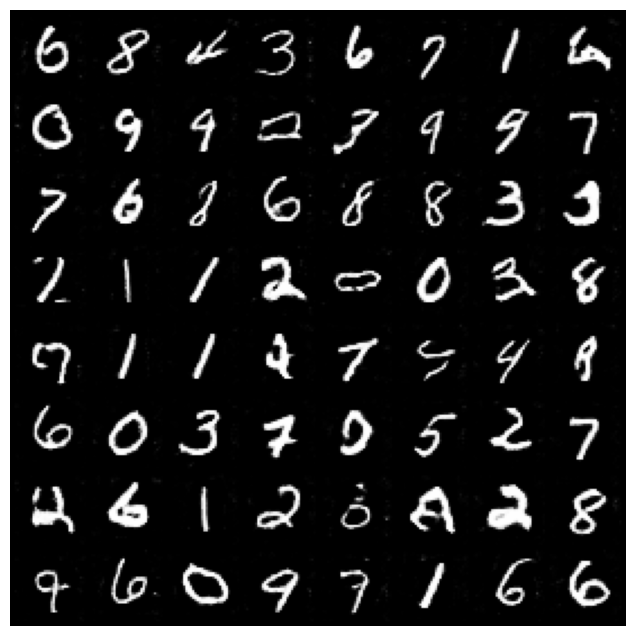

In [ ]:
import torch.optim as optim
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

# Inizialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netGdcgan = Generator().to(device)
netD = Discriminator().to(device)
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizerG = optim.Adam(netGdcgan.parameters(), lr=0.0001, betas=(0.5, 0.999))

num_epochs = 10
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
image_list = []

# Training
for epoch in range(num_epochs):
    for i, data in enumerate(trainloader, 0):
        ## Train Discriminator ##
        netD.zero_grad()
        real_images, _ = data
        real_images = real_images.to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), 1.0, device=device)
        output = netD(real_images)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netGdcgan(noise)
        label.fill_(0.0)
        output = netD(fake_images.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ## Train Generator ##
        netGdcgan.zero_grad()
        label.fill_(1.0)  # unsaturating trick
        output = netD(fake_images)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(trainloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Inspect images
        if i % 500 == 0:
            with torch.no_grad():
                fake = netGdcgan(fixed_noise).detach().cpu()
            grid = make_grid(fake, padding=2, normalize=True)
            image_list.append(grid)


fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.numpy(), (1, 2, 0)), animated=True)] for i in image_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())


## Assignment 4
Now that you have trained your first GAN, you have probably already looked at the generated images. They should look near-realistic if everything went well. But visual inspection is highly subjective, not scalable and difficult to reproduce, as we have covered in the lectures. In this assignment we will therefore implement a quantitative evaluation metric: the Fréchet Inception Distance (FID).

To calculate the FID, you need a pretrained network that acts as a feature extractor. In theory you can take any network you want, but it makes sense in this context to use a network that was trained on MNIST as well. We provide you with an external Python-file `mnist_extractor.py` that contains both a model definition and a method to download pretrained weights for this model. You can instantiate the pretrained model using the `mnist()` function. In the `extract()` method we have stripped the final output layer from the model, such that the feature vector of the prefinal layer is returned. Make sure to put the model in evaluation mode when extracting the features &ndash; this will disable the stochastic dropout layers.
NB: if you want, you can also use the MNIST classifier that you trained in the first lab session.

The FID requires that you fit two multivariate Gaussian distributions to the extracted feature vectors. For this, you can use the regular sample mean en sample covariance. Make good use of NumPy and SciPy to calculate these quantities, and use it as well to calculate vector norms, matrix square roots, traces...

Is your obtained FID a reasonable number? That's hard to say. FID is highly model-, dataset- and dataset-size-specific, so it can only be used to compare models to each other. Assessing the performance of a single, isolated model based on FID is difficult. As an exercise, try to increase e.g. the size of the test dataset and see how it affects the FID.

In [ ]:
import importlib.util
import sys

module_path = "mnist_extractor.py"

spec = importlib.util.spec_from_file_location("mnist_extractor", module_path)
mnist_extractor = importlib.util.module_from_spec(spec)
sys.modules["mnist_extractor"] = mnist_extractor
spec.loader.exec_module(mnist_extractor)

import torch
import numpy as np
from scipy.linalg import sqrtm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nz = 50

extractor = mnist_extractor.mnist().to(device)
extractor.eval()


transform = transforms.Compose([
    transforms.Pad(2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)


@torch.no_grad()
def get_features(images, batch_size=64):
    features = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size].to(device)
        if batch.ndim == 3:
            batch = batch.unsqueeze(1)
        feat = extractor.extract(batch)
        features.append(feat.cpu())
    return torch.cat(features, dim=0)

def calculate_fid(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return diff.dot(diff) + np.trace(sigma1 + sigma2 - 2.0 * covmean)
sample_sizes = [500, 1000, 2000, 5000]
fid_results = []

for N in sample_sizes:
    print(f"Calculating FID with {N} images...")

    #  Collect N real images
    real_images = []
    for i, (imgs, _) in enumerate(mnist_loader):
        real_images.append(imgs)
        if len(real_images) * imgs.size(0) >= N:
            break
    real_images = torch.cat(real_images, dim=0)[:N]

    # Generate N false images
    noise = torch.randn(N, nz, 1, 1, device=device)
    fake_images = netGdcgan(noise).cpu()

    # Extract features
    real_feat = get_features(real_images)
    fake_feat = get_features(fake_images)

    real_np = real_feat.numpy()
    fake_np = fake_feat.numpy()

    mu_real = real_np.mean(axis=0)
    sigma_real = np.cov(real_np, rowvar=False)
    mu_fake = fake_np.mean(axis=0)
    sigma_fake = np.cov(fake_np, rowvar=False)

    # Calculate FID
    fid_score = calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)
    print(f"📊 FID with {N} images: {fid_score:.4f}")
    fid_results.append((N, fid_score))

Calculating FID with 500 images...
📊 FID with 500 images: 12.2715
Calculating FID with 1000 images...
📊 FID with 1000 images: 11.0599
Calculating FID with 2000 images...
📊 FID with 2000 images: 11.8081
Calculating FID with 5000 images...
📊 FID with 5000 images: 6.5206


The Fréchet Inception Distance (FID) compares the distribution of real and generated image features. When the test set size increases:
- Better statistical estimates – Larger test sets provide more accurate estimates of the real distribution (mean and covariance), reducing noise in the FID calculation.
- Improved coverage – A bigger test set captures more of the real data's diversity, making the comparison to generated data more representative.
- Lower variance – Small test sets can cause unstable or inflated FID values due to statistical variance. Larger sets stabilize the metric.

## Assignment 5
In this next assignment we will implement a Wasserstein GAN (WGAN). You can recycle most of the code you have written until now. The generator and discriminator (called 'critic' in WGAN lingo) can be almost exact copies: the only detail that is different is that the critic is *not* a classifier, but should output continuous, unbounded values (both positive and negative).

To train your WGAN, we will follow closely the algorithm as sketched in the original paper (Arjovsky et al., 2017):

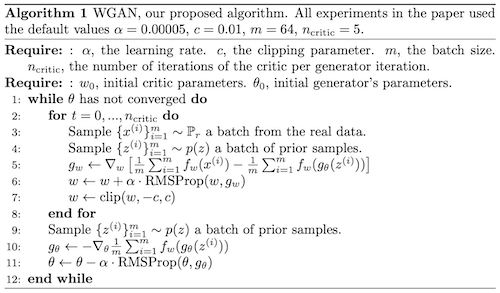

Some important details to which we want to draw your attention:
* The optimizer is RMSprop instead of Adam.
* The learning rate is really small!
* The critic is trained $n_{\text{critic}}$ times more than the generator.
* To train the critic, you need to perform gradient *ascent*; to train the generator, you perform gradient *descent* (which is the default).
* Take a look at the `clamp_` function in PyTorch to clip the weights of the critic.

You should see both the generator's loss and the Wasserstein estimate (i.e. the negative critic loss) going down during training. Due to the small learning rate, you will probably need more epochs compared to assigment 3.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nz = 50
ngf = 64
ndf = 64
num_epochs = 50
batch_size = 64
lr = 5e-5
n_critic = 5

# Dataset MNIST padded
transform = transforms.Compose([
    transforms.Pad(2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 1, 3, 1, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Critic (like D but without sigmoid)
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 2, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1)

# Inizialization
netGzgan = Generator().to(device)
netC = Critic().to(device)

optimizerG = optim.RMSprop(netGzgan.parameters(), lr=lr)
optimizerC = optim.RMSprop(netC.parameters(), lr=lr)

# Training
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        b_size = real_images.size(0)

        # === Training Critic ===
        for _ in range(n_critic):
            netC.zero_grad()

            # Fake
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_images = netGzgan(noise).detach()
            loss_C = -torch.mean(netC(real_images)) + torch.mean(netC(fake_images))
            loss_C.backward()
            optimizerC.step()

            # Clipping weights
            for p in netC.parameters():
                p.data.clamp_(-0.01, 0.01)

        # === Training Generator ===
        netGzgan.zero_grad()
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netGzgan(noise)
        loss_G = -torch.mean(netC(fake_images))  # Gradient descent
        loss_G.backward()
        optimizerG.step()

        # === Logs ===
        if i % 100 == 0:
            print(f"[{epoch}/{num_epochs}][{i}/{len(train_loader)}] Loss_C: {loss_C.item():.4f}  Loss_G: {loss_G.item():.4f}")


[0/50][0/938] Loss_C: -0.0288  Loss_G: 0.0093
[0/50][100/938] Loss_C: -0.2977  Loss_G: 0.1553
[0/50][200/938] Loss_C: -0.2574  Loss_G: 0.1808
[0/50][300/938] Loss_C: -0.3509  Loss_G: 0.1810
[0/50][400/938] Loss_C: -0.3768  Loss_G: 0.1938
[0/50][500/938] Loss_C: -0.0084  Loss_G: 0.1946
[0/50][600/938] Loss_C: -0.3795  Loss_G: 0.1953
[0/50][700/938] Loss_C: -0.3810  Loss_G: 0.1959
[0/50][800/938] Loss_C: -0.3819  Loss_G: 0.1965
[0/50][900/938] Loss_C: -0.3812  Loss_G: 0.1963
[1/50][0/938] Loss_C: -0.3724  Loss_G: 0.1918
[1/50][100/938] Loss_C: -0.3815  Loss_G: 0.1960
[1/50][200/938] Loss_C: -0.3824  Loss_G: 0.1970
[1/50][300/938] Loss_C: -0.3829  Loss_G: 0.1971
[1/50][400/938] Loss_C: -0.3828  Loss_G: 0.1970
[1/50][500/938] Loss_C: -0.3824  Loss_G: 0.1971
[1/50][600/938] Loss_C: -0.3833  Loss_G: 0.1972
[1/50][700/938] Loss_C: -0.3825  Loss_G: 0.1968
[1/50][800/938] Loss_C: -0.3804  Loss_G: 0.1967
[1/50][900/938] Loss_C: -0.0071  Loss_G: 0.1942
[2/50][0/938] Loss_C: -0.3791  Loss_G: 0.195

## Assignment 6
Compare the performance of the regular GAN (assignment 3) with that of the Wasserstein GAN (assignment 5) in terms of Fréchet Inception Distance (FID). What are your conclusions?

In [ ]:
def compute_fid_from_generator(generator, num_samples=1000):
    generator.eval()
    noise = torch.randn(num_samples, nz, 1, 1, device=device)
    with torch.no_grad():
        fake_images = generator(noise).cpu()

    # Get real images
    real_images = []
    for i, (imgs, _) in enumerate(train_loader):
        real_images.append(imgs)
        if len(real_images) * batch_size >= num_samples:
            break
    real_images = torch.cat(real_images, dim=0)[:num_samples]

    # Extract characteristics
    real_feat = get_features(real_images)
    fake_feat = get_features(fake_images)

    # Calculate statistics
    mu_real = real_feat.numpy().mean(axis=0)
    sigma_real = np.cov(real_feat.numpy(), rowvar=False)
    mu_fake = fake_feat.numpy().mean(axis=0)
    sigma_fake = np.cov(fake_feat.numpy(), rowvar=False)

    return calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)

# Comparison
fid_dcgan = compute_fid_from_generator(netGdcgan)
print(f"📊 FID (classic GAN): {fid_dcgan:.4f}")

fid_wgan = compute_fid_from_generator(netGzgan)
print(f"📊 FID (WGAN): {fid_wgan:.4f}")

📊 FID (classic GAN): 12.9458
📊 FID (WGAN): 15.4491


In the results the WGAN exhibits a higher FID compared to the classic GAN. One possible explanation is that the number of training epochs was insufficient. In our initial experiment, we trained the WGAN for 20 epochs and obtained an FID of approximately 24. We then extended the training to 50 epochs, which yielded the results reported above. However, since each training run took around two hours, we chose to conclude our experiments at 50 epochs.